In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('diabetes.csv')
df.head(5)

X = X = df.iloc[:,0:8].values
y = df.Outcome.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
model = LogisticRegression(penalty='none', max_iter=10000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

ytest_prob = model.predict_proba(Xtest)

# R2

In [5]:
def cal_r2(y, ypred):
    RSS = np.sum((y - ypred) ** 2)
    TSS = sum((y - np.mean(y))**2)
    return 1 - RSS/TSS

# Performance

- **TP = “True Positive”.** i.e. your classifier predicted 1; it was correct.
- **FP = “False Positive”.** i.e. your classifier predicted 1; it was incorrect (Type I error).
- **FN = “False Negative”.** i.e. your classifier predicted 0; it was incorrect (Type II error).
- **TN = “True Negative”.** i.e. your classifier predicted 0; it was correct.

## Measurement:

- Precision: What percentage of all positive predictions were correct?
  $$
  Precision = \frac{\# \ \text{True Positive}}{\#\ \text{Predicted Positive}}
  $$
- Recall: What percentage of all positive samples were recalled?

$$
Recall = \frac{\# \ \text{True Positive}}{\# \ \text{Class Positive}}
$$

- F-Measure: A combined metric which accounts for precision and recall in a single measure.

$$
F-Measure = 2 * (\frac{\text{Precision} * \text{Recall}}{\text{Precision} + {Recall}})
$$


In [6]:
def compute_performance(ypred, ytest, classes):
    tp = sum(np.logical_and(ypred == classes[1], ytest == classes[1]))
    tn = sum(np.logical_and(ypred == classes[0], ytest == classes[0]))
    fp = sum(np.logical_and(ypred == classes[1], ytest == classes[0]))
    fn = sum(np.logical_and(ypred == classes[0], ytest == classes[1]))

    return tp, tn, fp, fn

tp, tn, fp, fn = compute_performance(ypred, ytest, model.classes_)
Acc = (tp + tn) / (tp + tn + fp + fn)
print("Acc: %.5f" % Acc)

def compute_performance_2(yhat, y, classes):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))

    # print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
        
    # print("Accuracy:",round(acc,3),"Recall:",round(recall,3),
    #       "Sensitivity:",round(sensitivity,3),"Specificity:",round(specificity,3))
    return acc, recall, sensitivity, specificity

Acc: 0.82468


# Threshold

In [7]:
threshold = 0.6

ytest_prob = model.predict_proba(Xtest)
ypred = model.classes_[(ytest_prob[:,1]>threshold).astype(int)]
tp, tn, fp, fn = compute_performance(ypred, ytest, model.classes_)
Acc = (tp + tn) / (tp + tn + fp + fn)
print("Acc: %.5f" % Acc)

Acc: 0.81818


# ROC and AUC

- If Area Under Receiver Operating
  Characteristic Curve (AUROC) is
  1, classifier is perfect
- If AUROC is 0.5, classifier is no
  better than random chance.
- If AUROC is 0, classifier is
  worst possible (TPR=0, FPR=1)

classifier (all feature): 0.8665738715450387


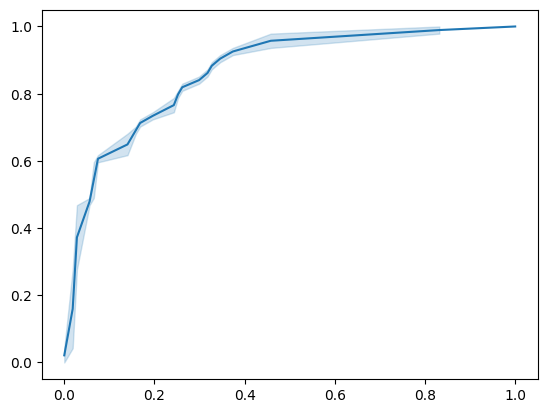

In [8]:
fpr, tpr, _ = roc_curve(ytest, ytest_prob[:,1], pos_label=1)
ax = sns.lineplot(x = fpr, y = tpr)

AUC = auc(fpr, tpr)
print("classifier (all feature): "+ str(AUC))

# Class Balanced

In [9]:
df = pd.read_csv('diabetes.csv')
counts= df.Outcome.value_counts()

baseline_accuracy = round(counts[0]/(counts[0]+counts[1]), 3)
print("Baseline Accuracy is:", baseline_accuracy)

Baseline Accuracy is: 0.651


# Learning Curve

In [ ]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)              